# 팩터 모델을 활용한 포트폴리오 최적화(~4/10)

우리는 여태껏 Alpha Factor와 Risk Factor, 그리고 그 둘을 이용한 포트폴리오 최적화에 대해 배웠습니다. 이번 과제를 통해 큰 흐름을 익히셨으면 합니다. 이번 과제는 다음의 4가지 단계로 이루어지며 각 단계별로 문제가 있습니다.

1. 1년 모멘텀 알파 팩터 생성 후 가장 최신 날짜의 알파 벡터 구하기
2. PCA를 사용해 Statistical Risk Model 설계하기
3. 알파 벡터와 Risk Model을 활용해 포트폴리오 최적화 식 정의하기
4. 최적화된 포트폴리오 가중치 도출하기

그러면 시작해봅시다!

# Imports & 데이터 준비

실제 주가 데이터가 아니라 임의로 만든 데이터를 사용하겠습니다. 

'Stock Price.csv' 파일을 읽어와서 price_df에 담고 로그 가격으로 변환해 log_price_df에 바인딩하겠습니다.

또한, 일별 수익률 데이터 프레임인 returns_df도 정의하겠습니다.

In [ ]:
from pykrx import stock
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore
import cvxpy as cvx

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10.0, 6.0]
%matplotlib inline

In [ ]:
price_df = pd.read_csv('Stock Price.csv', index_col='date')
log_price_df = np.log(price_df)

returns_df = (log_price_df-log_price_df.shift(1))[1:]
returns_df

# 1. 1년 모멘텀 알파 팩터 생성 후 가장 최신 날짜의 알파 벡터 구하기

# Quiz 1. 알파 벡터 구하기

일별로 1년 모멘텀 팩터를 구하고 rank와 zscore를 순서대로 계산한 후 가장 최신 날짜(2017-06-30)의 팩터값을 구해주세요

포트폴리오 최적화에 사용될 이 팩터값을 앞으로 '알파 벡터'라 부르겠습니다.

**참고)** 

rank와 zscore는 일별로 계산돼야 합니다. 가령, xxxx-yy-zz날의 팩터값은 [1,2,3] 순위를 가질 것이고, 이를 zscore로 한 번 더 변환하면 [-1,22, 0, 1.22]와 같이 값이 나올 것입니다.

In [ ]:
# TO DO...

# 2. PCA를 사용해 Statistical Risk Model 설계하기

A,B,C 3개의 주식 수익률로 이루어진 3차원의 데이터를 2개의 Risk Factor로 설명하고자 합니다. n_components=2로 하겠습니다.

In [ ]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

num_factor_exposures=2
svd_solver='full'

pca = fit_pca(returns_df, num_factor_exposures, svd_solver)

In [ ]:
# 2개의 Risk Factor로 설명되는 원 데이터의 분산을 살펴봅시다
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);
print(f'{num_factor_exposures}개의 Risk Factor에 의해 설명되는 데이터의 분산 : {sum(pca.explained_variance_ratio_)*100}%')

## 2-1. B(Factor Exposure) 구하기

보기 쉽게 전부 데이터프레임 형식으로 만들어주겠습니다. index와 column은 아래와 같이 설정하시면 됩니다. 

데이터로 어떤 값이 들어가는지에 집중해주세요!

In [ ]:
factor_beta = pd.DataFrame(pca.components_.T, index=returns_df.columns, columns=np.arange(num_factor_exposures))
factor_beta

## 2-2. f(Factor Return) 구하기

In [ ]:
factor_return = pd.DataFrame(pca.transform(returns_df), index=returns_df.index, columns=np.arange(num_factor_exposures))
factor_return

## 2-3. s(Specific Return) 구하고 S 구하기

S = s의 분산의 대각행렬

전체 데이터에서 fB^T(Common Return)을 빼서 s를 구해줍니다.

In [ ]:
common_returns = pd.DataFrame(np.dot(factor_return, factor_beta.T), index=returns_df.index, columns=returns_df.columns)
specific_returns = returns_df - common_returns

# diagonal을 취하는 이유 -> 행렬 계산을 위해
idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(specific_returns)), index=returns_df.columns, columns=returns_df.columns)
idiosyncratic_var_matrix

## 2-4. F(Factor Covariance) 구하기

In [ ]:
factor_covariance_matrix = np.cov(factor_return.T)
factor_covariance_matrix

# Quiz 2. 포트폴리오 공분산 계산하기

위에서 구한 값들을 사용해 포트폴리오의 공분산을 계산해주세요

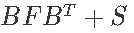

In [ ]:
# TO DO...

# 3. 알파 벡터와 Risk Model을 활용해 포트폴리오 최적화 식 정의하기

# Quiz 3. 최적화 함수 완성하기

아래는 cvxpy를 이용해 최적화된 포트폴리오 가중치를 찾는 함수입니다. 

Constraint는 주어져 있습니다. Constraint외의 포트폴리오 최적화 식을 완성해 최적화된 가중치를 리턴하는 find_optimal_holdings 함수를 정의해주세요.

최적화 식의 기본 틀은 다음과 같습니다.

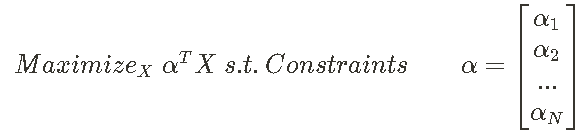

In [ ]:
def find_optimal_holdings(
    alpha_vector, # Quiz1에서 구한 알파 벡터
    risk_cap=0.05,
    factor_max=10.0,
    factor_min=-10.0,
    x_max=0.55,
    x_min=-0.55):
    
    # TO DO...

    constraints = [
        sum(cvx.abs(X)) <= 1.0,
        sum(X) == 0.0,
        X <= x_max,
        X >= x_min,
        portfolio_risk <= risk_cap,
        B.values.T@X <= factor_max,
        B.values.T@X >= factor_min
    ]
    

    return # optimized weight

# Quiz 4. Constraint 해석하기

위의 최적화 함수에서 constraints로 7개를 주었습니다. 각각이 어떤 제약조건이며 무엇을 의미하는지 설명해주세요.

`sum(cvx.abs(X)) <= 1.0` : 

`sum(X) == 0.0` : 

`X <= x_max` : 

`X >= x_min` : 

`portfolio_risk <= risk_cap` : 

`B.values.T@X <= factor_max` : 

`B.values.T@X >= factor_min` : 


# 4. 최적화된 포트폴리오 가중치 도출하기

# Quiz 5. 최적해 구하기

Quiz 3에서 구한 find_optimal_holdings함수를 이용해 최적화된 포트폴리오 가중치를 구해주세요

In [ ]:
# TO DO...

# 수고하셨습니다!